# Bite Analysis

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fft import fftshift
import seaborn as sns
import matplotlib.pylab as pl
import bites as bt

In [2]:
plt.rcParams['pdf.fonttype'] = 42

In [3]:
vid_folder = r"/Users/chitniss/Documents/GitHub/bite-tracks/sample_bite/"
plot_folder = r"/Users/chitniss/Documents/GitHub/bite-tracks/plots/"
filename = "Adrill_C001H001S0048DLC_resnet50_skitJul21shuffle1_4800.csv"

In [4]:
legDf = pd.read_csv(vid_folder+filename,header=[1,2],index_col=0)

Specify camera fps

In [5]:
camera_fps = 250 #camera fps

In [6]:
n = len(legDf)
T = n/camera_fps

Extract bite session from labium data. The `lab3` anchor point should not move much during biting.

In [7]:
vel_lab3 = np.sqrt((((legDf.loc[:,('lab3',
                'x')].diff())**2).values)+(((legDf.loc[:,('lab3',
                'y')].diff())**2).values))

In [8]:
window = 1
vel_lim = 10

In [9]:
t_bite_start = np.where(bt.moving_average((vel_lab3<=vel_lim)|(np.isnan(vel_lab3)),window=window,T=T)>=0.99)[0][0]*(T/n)
t_bite_end = np.where(bt.moving_average((vel_lab3<=vel_lim)|(np.isnan(vel_lab3)),window=window,T=T)<=0.95)[0][0]*(T/n)
t_bite = t_bite_end-t_bite_start
print("bite start: ", t_bite_start, "; bite end: ", t_bite_end)

bite start:  0.0 ; bite end:  15.74


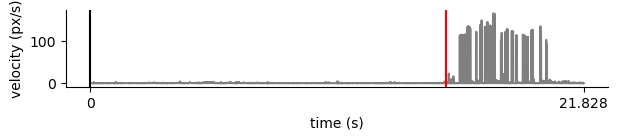

In [10]:
plt.figure(figsize = (7,1))
plt.plot(vel_lab3,color='gray');
plt.axvline(t_bite_start*n/T,color='k'); plt.axvline(t_bite_end*n/T,color='r');
sns.despine();
plt.xticks([0,n],[0,T]); plt.xlabel('time (s)'); plt.ylabel('velocity (px/s)');
plt.savefig(plot_folder+"bite_segmentation.pdf",bbox_inches = "tight")

## Moving to Labium Frame

In [11]:
time = np.linspace(0,t_bite,round(n*t_bite/T))

In [12]:
parts = ('tar1','tar2','tar3','lab1','lab2','lab3')

In [13]:
derDf = bt.derive(legDf,T,t_bite_start,t_bite_end,ctr='lab3')

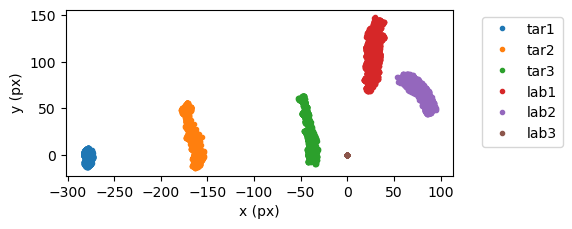

In [14]:
plt.figure(figsize = (5,5))
plt.axes().set_aspect('equal');
plt.plot(derDf.loc[:,(parts,('x'))].values,
         derDf.loc[:,(parts,('y'))].values,'.');
plt.legend(list(parts),bbox_to_anchor = (1.3,1));
plt.xlabel('x (px)'); plt.ylabel('y (px)');
plt.savefig(plot_folder+"bodyparts_labium_frame_xy.pdf",bbox_inches = "tight")

# Bodypart Velocity Analysis

In [15]:
time_scale = 0.5 #for smoothing in second
variable = 'speed' #.shift(periods=(-int(w/2)))

In [16]:
w = round(time_scale*n/T)
vec = derDf.loc[:,(parts[:3],(variable))].rolling(w,center=True).mean().values
vec1 = derDf.loc[:,(parts[3:],(variable))].rolling(w,center=True).mean().values

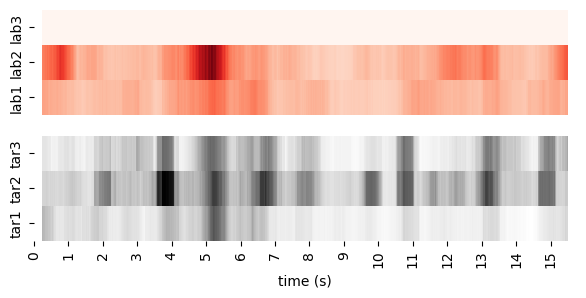

In [17]:
fig,ax = plt.subplots(2,1,figsize = (7,3))
sns.heatmap(vec.T,cmap='Greys',cbar=False,ax=ax[1]);

ax[1].set_ylim(0,3);
ax[1].set_xticks(np.arange(0,n*t_bite/T,1*n/T),np.arange(0,t_bite,1).round().astype('int'));
ax[1].set_yticks(np.arange(np.shape(vec)[1])+0.5,list(parts[:3]));
ax[1].set_xlabel('time (s)');

sns.heatmap(vec1.T,cmap='Reds',cbar=False,ax=ax[0]);

ax[0].set_ylim(0,3);
ax[0].axes.get_xaxis().set_visible(False)
ax[0].set_yticks(np.arange(np.shape(vec)[1])+0.5,list(parts[3:]));
plt.savefig(plot_folder+"bodyparts_"+variable+"_smoothed_"+str(time_scale)+".pdf",bbox_inches = "tight")

# Joint Analysis

## Frequency Analysis

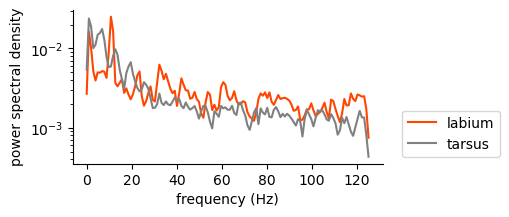

In [18]:
plt.figure(figsize = (4,2))
f, Pxx_den = signal.welch(derDf.loc[:,('lab2','speed')].dropna().values, fs=n/T)
f1, Pxx_den1 = signal.welch(derDf.loc[:,('tar2','speed')].dropna().values, fs=n/T)
plt.semilogy(f, Pxx_den, color='orangered')
plt.semilogy(f1, Pxx_den1, color='gray')
plt.xlabel('frequency (Hz)')
plt.ylabel('power spectral density')
plt.legend(['labium','tarsus'], loc = 'lower right', bbox_to_anchor = (1.4,0));
sns.despine();
plt.savefig(plot_folder+"frequency_spectrum_joints.pdf",bbox_inches = "tight")

# Angle Analysis

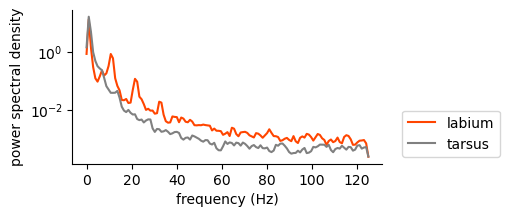

In [19]:
plt.figure(figsize = (4,2))
f, Pxx_den = signal.welch(bt.angle_part(derDf,'lab'), fs=n/T)
f1, Pxx_den1 = signal.welch(bt.angle_part(derDf,'tar'), fs=n/T)
plt.semilogy(f, Pxx_den, color='orangered')
plt.semilogy(f1, Pxx_den1, color='gray')
plt.xlabel('frequency (Hz)')
plt.ylabel('power spectral density')
sns.despine()
plt.legend(['labium','tarsus'], loc = 'lower right', bbox_to_anchor = (1.4,0));
plt.savefig(plot_folder+"frequency_spectrum_joint_angles.pdf",bbox_inches = "tight");

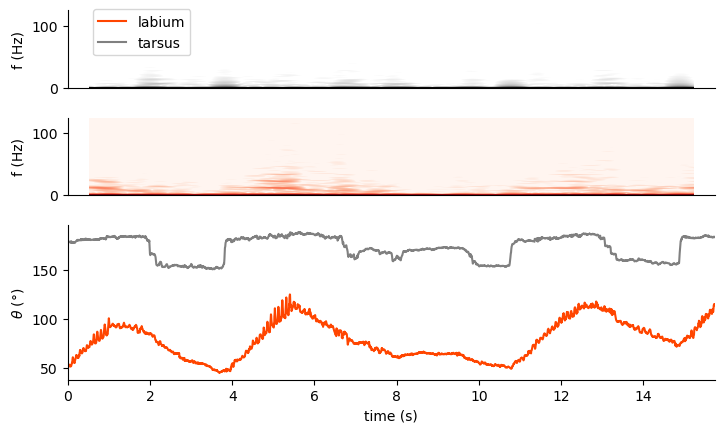

In [20]:
fig,ax = plt.subplots(3,1,figsize = (7,4),gridspec_kw={'height_ratios': [1, 1, 2]})

sns.despine(ax=ax[2]); sns.despine(ax=ax[1]); sns.despine(ax=ax[0]);
plt.tight_layout(pad=0.05)

_,_,_,_ = ax[1].specgram(bt.angle_part(derDf,'lab'), Fs=n/T, cmap='Reds', scale='dB', vmin=-20, noverlap=255)
_,_,_,_ = ax[0].specgram(bt.angle_part(derDf,'tar'), Fs=n/T, cmap='Greys', scale='dB', vmin=-20, noverlap=255)
ax[0].set_ylabel('f (Hz)'); ax[1].set_ylabel('f (Hz)')
ax[0].axes.get_xaxis().set_visible(False)
ax[0].set_xlim(0,t_bite); ax[1].set_xlim(0,t_bite);
ax[1].axes.get_xaxis().set_visible(False);

ax[2].plot(time,bt.angle_part(derDf,'lab'),color='orangered');
ax[2].plot(time,bt.angle_part(derDf,'tar'),color='gray');
ax[2].set_xlabel('time (s)');
ax[2].set_ylabel(r'$\theta$ (°)');
ax[2].set_xlim(0,t_bite);
ax[2].legend(['labium','tarsus'],loc='lower right',bbox_to_anchor = (0.2,2.05));
plt.savefig(plot_folder+"spectrogram_joint_angles.pdf",bbox_inches = "tight");

## Leg Triggered Labial Movement

In [21]:
time_lim = 2 #sec
win_lim = int(time_lim*n/T)
mode = 'insertion'

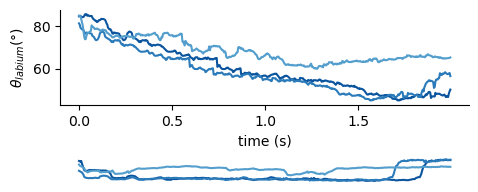

In [22]:
sns.set_palette('Blues_r')
fig, ax = plt.subplots(2,1,figsize = (5,2.5), gridspec_kw={'height_ratios': [4, 1]})
plt.tight_layout(pad=1.75)
for pt in bt.get_leg_time(derDf,T=T,mode=mode):
    ax[0].plot(bt.angle_part(derDf,'lab')[pt:pt+win_lim])
    ax[1].plot(bt.angle_part(derDf,'tar')[pt:pt+win_lim])
sns.despine(ax=ax[0]); plt.axis('off');
ax[0].set_xticks(np.arange(0,win_lim,0.5*n/T),np.arange(0,win_lim*T/n,0.5).round(2));
ax[0].set_ylabel(r"$\theta_{labium} (°)$");
ax[0].set_xlabel("time (s)");
plt.savefig(plot_folder+"leg_triggered_labial_movement_"+mode+".pdf",bbox_inches = "tight");
sns.set_palette('tab10');

## Distribution of Leg Joint Angles

/Users/chitniss/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chitniss/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chitniss/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


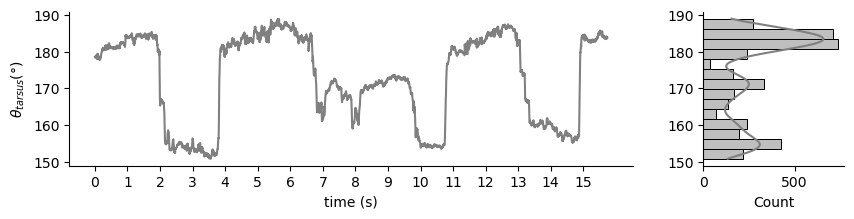

In [23]:
fig,ax = plt.subplots(1,2,figsize = (10,2),gridspec_kw={'width_ratios': [4, 1]})
sns.histplot(y = bt.angle_part(derDf,'tar'),kde=True,color='gray');
sns.despine(ax=ax[1]); sns.despine(ax=ax[0]);
sns.lineplot(bt.angle_part(derDf,'tar'),ax=ax[0],color='gray');
ax[0].set_xticks(np.arange(0,n*t_bite/T,1*n/T),np.arange(0,t_bite,1).round().astype('int'));
ax[0].set_xlabel('time (s)');
ax[0].set_ylabel(r'$\theta_{tarsus} (°)$');
plt.savefig(plot_folder+"tarsal_joint_angle_dist.pdf",bbox_inches = "tight");

# Needle Depth and Leg Straightness

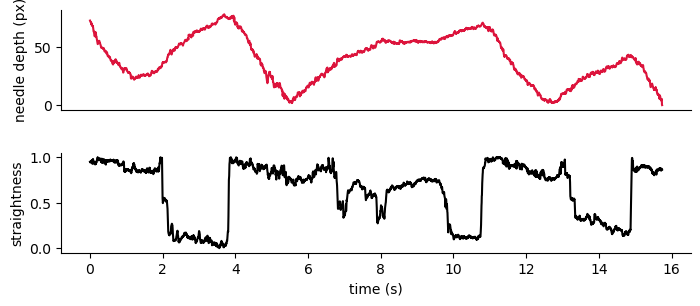

In [24]:
fig,ax = plt.subplots(2,1,figsize = (7,3))
plt.tight_layout(pad=1)
ax[0].plot(time,bt.insert_length(derDf),'crimson')
ax[1].plot(time,bt.straightness(derDf),'black')
ax[0].set_ylabel("needle depth (px)");
ax[1].set_ylabel("straightness");
ax[1].set_xlabel("time (s)");
ax[0].axes.get_xaxis().set_visible(False)
sns.despine();
plt.savefig(plot_folder+"needle_depth_leg_straightness.pdf",bbox_inches = "tight");

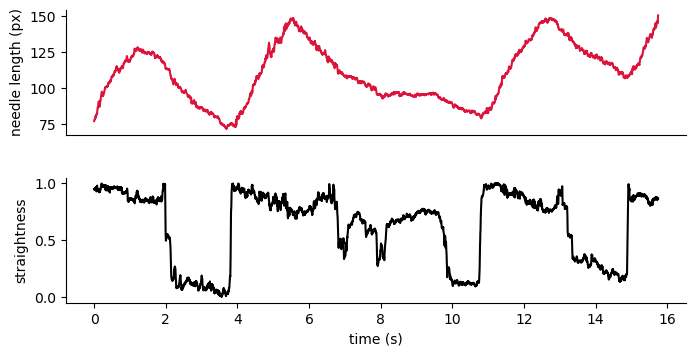

In [25]:
fig,ax = plt.subplots(2,1,figsize = (7,3.5))
plt.tight_layout(pad=1)
ax[0].plot(time,bt.needle_length(derDf),'crimson')
ax[1].plot(time,bt.straightness(derDf),'black')
ax[0].set_ylabel("needle length (px)");
ax[1].set_ylabel("straightness");
ax[1].set_xlabel("time (s)");
ax[0].axes.get_xaxis().set_visible(False)
sns.despine();
plt.savefig(plot_folder+"needle_length_leg_straightness.pdf",bbox_inches = "tight");

In [26]:
time_lim = 2 #sec
win_lim = int(time_lim*n/T)
mode = 'insertion'

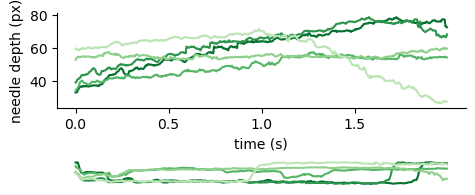

In [27]:
sns.set_palette('Greens_r')
fig, ax = plt.subplots(2,1,figsize = (5,2.5), gridspec_kw={'height_ratios': [4, 1]})
plt.tight_layout(pad=1.75)
for pt in bt.get_leg_time(derDf,T=T,mode=mode,variable='straightness'):
    ax[0].plot(bt.insert_length(derDf)[pt:pt+win_lim])
    ax[1].plot(bt.straightness(derDf)[pt:pt+win_lim])
sns.despine(ax=ax[0]); plt.axis('off');
ax[0].set_xticks(np.arange(0,win_lim,0.5*n/T),np.arange(0,win_lim*T/n,0.5).round(2));
ax[0].set_ylabel("needle depth (px)");
ax[0].set_xlabel("time (s)");
plt.savefig(plot_folder+"straightness_triggered_needle_movement_"+mode+".pdf",bbox_inches = "tight");
sns.set_palette('tab10');

## Plot movie with leg tracking

In [52]:
# Load the video
video = bt.videoExtract(vid_folder+filename.replace('.csv','_labeled.mp4'))
video_bite = video[int(t_bite_start*n/T):int(t_bite_end*n/T),:,:,:]

In [104]:
import matplotlib.animation as animation
import IPython.display as display

In [105]:
fps = 30

In [140]:
i = 0

# Create the figure and grid layout
fig = plt.figure(figsize=(12, 4))

# Define gridspec for custom subplot layout
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1.5], height_ratios=[1, 1])

# Add the video to the first subplot
ax1 = fig.add_subplot(gs[:, 0])
im = ax1.imshow(video_bite[i]);
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

# Add quantification to the second subplot
line1, = ax2.plot(time[:i],bt.needle_length(derDf)[:i],'firebrick')
line2, = ax3.plot(time[:i],bt.straightness(derDf)[:i],'royalblue')
ax2.set_ylabel("Mouthpart", fontsize=10);
ax3.set_ylabel("Tarsus Straightness", fontsize = 10);
ax2.set_xlim(0,time.max());
ax3.set_xlim(0,time.max());
ax2.set_xticklabels([]); ax3.set_xlabel("time (s)");
ax2.set_ylim(-10, 150)
ax3.set_ylim(0, 1)
ax2.set_yticks([60, 160])
ax2.set_yticklabels(['deep', 'shallow'])
ax2.axhline(0,color='black',linewidth=0.75)
ax2.text(6,10,'skin surface',fontsize=10,color='black')

ax3.set_yticks([0, 1])
ax3.set_yticklabels(['bent', '      flat'])
#ax2.spines['top'].set_color('black')
#ax2.spines['top'].set_linewidth(1)

sns.despine(ax=ax2); sns.despine(ax=ax3);

def animate(i):
    
    im.set_array(video_bite[i])
    line1.set_xdata(time[:i])
    line1.set_ydata(bt.needle_length(derDf)[:i])
    line2.set_xdata(time[:i])
    line2.set_ydata(bt.straightness(derDf)[:i])

ani = animation.FuncAnimation(
    fig, animate, interval=1000/fps, frames = np.arange(0,len(time),5), repeat = False)

v = ani.to_html5_video()
html = display.HTML(v)
display.display(html)
plt.close()
ani.save(plot_folder+'leg-tarsus_tracking.mp4', fps=fps, dpi=300, extra_args=['-vcodec', 'libx264'])